Logistic Regression classifier  

In [2]:
# Import

from hn.load_data import load_data

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, svm, decomposition
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [30]:
# Preprocessing function of PCA

def data_preprocessing_pca(X_train, X_validation):
    ''' Data preprocessing: first scaling and then PCA with a optimized number of components '''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Principle component analysis
    # Using the cumulative summation of the explained variance, we concluded that in
    # order to retain 95% of the variance 30 components are needed.

    pca = decomposition.PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca

In [12]:
# Preprocessing function of Univariate Analysis 

def data_preprocessing_uni(X_train, y_train, X_validation):
    '''Data preprocessing: first scaling and then univariate analysis'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=5)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score'] # Naming the dataframe columns
    best_features = featureScores.nlargest(10,'Score')['Specs']

    X_train_uni = df_X_train_scaled[best_features]
    X_validation_uni = df_X_validation_scaled[best_features]

    return X_train_uni, X_validation_uni

In [5]:
# Learning curve function

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

In [6]:
# Loading of the data 

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) 
# 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

# Split data in a train and test set
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y, stratify=y, test_size=0.2)

The number of samples: 113
The number of features: 159


Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for PCA preprocessing: 0.8238636363636364


<module 'matplotlib.pyplot' from 'C:\\Users\\eline\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

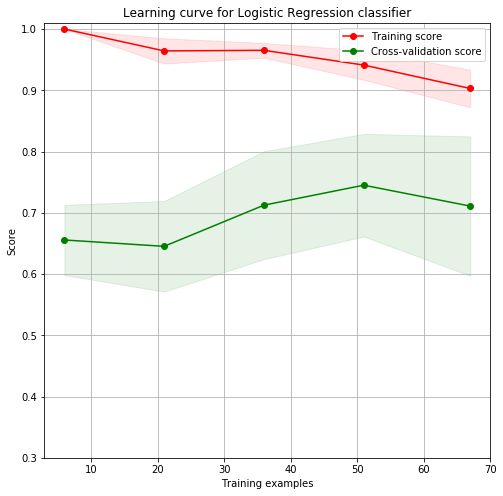

In [32]:
# Logistic Regression
# Preprocessing: PCA
# GridsearchCV for parameter tuning
# Applied on train-validation data

# Set up the GridSearch with a set of parameters
cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)

grid_param = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20),'solver' : ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid=grid_param, cv=cv_4fold,n_jobs=-1,scoring='roc_auc') 

X_train_pca, _ = data_preprocessing_pca(split_X_train, split_X_test)
grid_search.fit(X_train_pca, split_y_train)


# Show the complete results of the cross validation
pd.DataFrame(grid_search.cv_results_)
print(f'Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for PCA preprocessing: {grid_search.best_score_}')

title = 'Learning curve for Logistic Regression classifier'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_learning_curve(grid_search.best_estimator_, title, X_train_pca, split_y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)

In the PCA preprocessing, a lot of variance can still be seen from the learning curve, both in the graph as when we run it multiple times. To try and solve this problem a bit more, and therefore to generalize better, we tried a Univariate feature selection. With 10 best features, it was still giving a great variance. Therefore, we tuned the parameter a bit down to 5 best features. This seems to improve the AUC score. This can both be seen in the attribute of GridSearchCV.best_score_ as can be seen in the learning curve graph where the training and validation error seem to converge within the sample size that we have. 

Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for Univariate preprocessing: 0.8524449035812672


<module 'matplotlib.pyplot' from 'C:\\Users\\eline\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

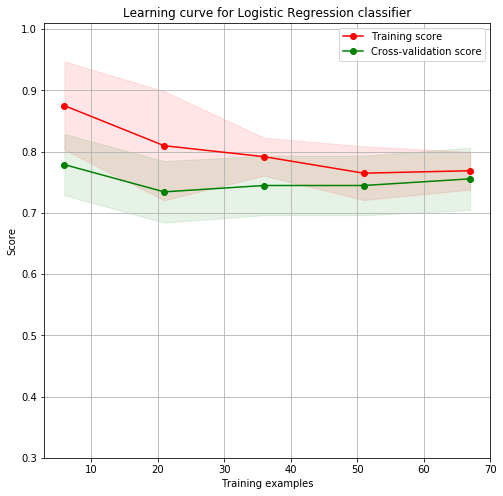

In [35]:
# Logistic Regression
# Preprocessing: Univariate Analysis
# GridsearchCV for parameter tuning
# Applied on train-validation data

# Set up the GridSearch with a set of parameters
cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)

grid_param = {'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20),'solver' : ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid=grid_param, cv=cv_4fold,n_jobs=-1,scoring='roc_auc') 

# Data preprocessing 
X_train_uni, _ = data_preprocessing_uni(split_X_train, split_y_train, split_X_test)
grid_search.fit(X_train_uni, split_y_train)


# Show the complete results of the cross validation
pd.DataFrame(grid_search.cv_results_)
print(f'Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for Univariate preprocessing: {grid_search.best_score_}')

title = 'Learning curve for Logistic Regression classifier'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plot_learning_curve(grid_search.best_estimator_, title, X_train_uni, split_y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)

In [36]:
# Logistic Regression
# Preprocessing: Univariate Analysis
# GridsearchCV for parameter tuning
# Applied on test data

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
grid_param = {'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20),'solver' : ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(),param_grid=grid_param, cv=cv_4fold,n_jobs=-1, scoring='roc_auc') 

train_all = []
test_all = []
for _ in range(4):
    for train_index, test_index in cv_4fold.split(data, y):
        train_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_uni, X_validation_uni = data_preprocessing_uni(X_train, y_train, X_test)

        grid_search.fit(X_train_uni, y_train) 
        clf_lr = grid_search.best_estimator_
        
        # Test
        train_proba = clf_lr.predict_proba(X_train_uni)[:, 1]
        test_proba = clf_lr.predict_proba(X_validation_uni)[:, 1]

        score_train = metrics.roc_auc_score(y_train, train_proba)
        score_test = metrics.roc_auc_score(y_test, test_proba)

        train_scores.append(score_train)
        test_scores.append(score_test)

    train_all.append(train_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(train_all)
all_test = np.array(test_all)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(f'The resulting method gives an AUC of {test_scores_mean} +- {test_scores_std}')

The resulting method gives an AUC of [0.84566327] +- [0.06314742]
